# Evaluate forecasts

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '/data/weather-benchmark/5.625deg/'
PREDDIR = '/data/weather-benchmark/predictions/'

## Load data

In [5]:
# Load the validation subset of the data: 2017 and 2018
z500_valid = load_test_data(f'{DATADIR}geopotential_500', 'z')
t850_valid = load_test_data(f'{DATADIR}temperature_850', 't')
valid_data = xr.merge([z500_valid, t850_valid])

In [6]:
persistence = xr.open_dataset(f'{PREDDIR}persistence.nc').drop('level')
climatology = xr.open_dataset(f'{PREDDIR}climatology.nc')
weekly_climatology = xr.open_dataset(f'{PREDDIR}weekly_climatology.nc')

In [7]:
lr_3d = xr.open_dataset(f'{PREDDIR}fc_lr_3d.nc')
lr_5d = xr.open_dataset(f'{PREDDIR}fc_lr_5d.nc')
lr_6h_iter = xr.open_dataset(f'{PREDDIR}fc_lr_6h_iter.nc')

In [8]:
cnn_3d = xr.open_dataset(f'{PREDDIR}fccnn_3d.nc')
cnn_5d = xr.open_dataset(f'{PREDDIR}fccnn_5d.nc')
cnn_6h_iter = xr.open_dataset(f'{PREDDIR}fccnn_6h_iter.nc')

In [9]:
# See next section on how to compute these from the raw data.
tigge = xr.open_dataset(f'{PREDDIR}/tigge_5.625deg.nc')
t21 = xr.open_dataset(f'{PREDDIR}/t21_5.625deg.nc')

## TIGGE and IFT T21 data

For these we need to do some preprocessing to get the data into the same format as our ERA5 files.

In [25]:
# Convert from geopotential height to geopotential
tigge_raw = xr.open_mfdataset('/data/weather-benchmark/tigge/5.625deg/*').squeeze()

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.The datasets supplied require both concatenation and merging. From
xarray version 0.14 this will operation will require either using the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset), with a nested list structure such that you can combine
along the dimensions None. Alternati

In [26]:
tigge_raw['z'] = tigge_raw.gh * 9.807
tigge_raw

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 12768)
Coordinates:
    lev      float64 5e+04
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-11-05T12:00:00
Data variables:
    gh       (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
    z        (time, lat, lon) float32 dask.array<chunksize=(1302, 32, 64), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions:  CF-1.4
    history:      Tue Dec 03 13:14:18 2019: cdo -f nc copy /data/weather-benc...
    institution:  European Centre for Medium-Range Weather Forecasts
    CDO:          Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/...

In [78]:
t21_raw = xr.open_mfdataset(f'/media/rasp/Elements/weather-benchmark/IFS_T21/raw/output_pl_5.625*.nc')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


In [79]:
t21_raw['lat'] = -tigge_raw.lat
t21_raw = t21_raw.roll(lon=32)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: roll_coords will be set to False in the future. Explicitly set roll_coords to silence warning.
  


In [80]:
def convert_time(ds, nlead_time):
    """Converts to lead_time format"""
    init_times = ds.time[::nlead_time]
    lead_times = xr.DataArray(
        np.arange(0, 6*nlead_time, 6), dims=['lead_time'], coords={'lead_time': np.arange(0, 6*nlead_time, 6)})
    
    coords = dict(ds.coords); coords.pop('time')
    coords['time'] = init_times; coords['lead_time'] = lead_times
    ds_by_lead = xr.merge([xr.DataArray(
        ds[var].values.reshape((len(init_times), len(lead_times)) + ds[var].shape[1:]),
        dims = ('time', 'lead_time') + ds[var].dims[1:],
        coords = coords,
        name=var
    ) for var in ds])
    return ds_by_lead

In [81]:
tigge = convert_time(tigge_raw, 21)
t21 = convert_time(xr.Dataset({'z': t21_raw.z.sel(lev=5e4), 't': t21_raw.t.sel(lev=8.5e4)}, compat='override'), 29)

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The `compat` argument to Dataset is deprecated and will be removed in 0.14.Instead, use `merge` to control how variables are combined
  


In [82]:
# Save for later usage
tigge.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')
t21.to_netcdf(f'{PREDDIR}/t21_5.625deg.nc')

## Compute RMSE

In [14]:
t21

<xarray.Dataset>
Dimensions:    (lat: 32, lead_time: 29, lon: 64, time: 1460)
Coordinates:
    lev        float64 5e+04
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... -16.88 -11.25 -5.625
  * lat        (lat) float64 87.19 81.56 75.94 70.31 ... -75.94 -81.56 -87.19
  * time       (time) datetime64[ns] 2017-01-01 ... 2017-12-31T18:00:00
  * lead_time  (lead_time) int64 0 6 12 18 24 30 36 ... 138 144 150 156 162 168
    level      int32 850
Data variables:
    z          (time, lead_time, lat, lon) float32 51077.49 ... 50947.074
    t          (time, lead_time, lat, lon) float32 252.08476 ... 260.23413
    z_rmse     (lead_time) float64 128.1 161.3 195.0 233.5 ... 862.6 874.0 884.7
    t_rmse     (lead_time) float64 1.591 1.734 1.929 2.14 ... 4.768 4.807 4.843

In [10]:
tigge = tigge.merge(evaluate_iterative_forecast(tigge, valid_data)).load()
t21 = t21.merge(evaluate_iterative_forecast(t21, valid_data)).load()


In [11]:
persistence = persistence.merge(evaluate_iterative_forecast(persistence, valid_data)).load()
climatology = climatology.merge(compute_weighted_rmse(climatology, valid_data)).load()
weekly_climatology = weekly_climatology.merge(compute_weighted_rmse(weekly_climatology, valid_data)).load()

In [12]:
lr_6h_iter = lr_6h_iter.merge(evaluate_iterative_forecast(lr_6h_iter, valid_data)).load()
lr_3d = lr_3d.merge(compute_weighted_rmse(lr_3d, valid_data)).load()
lr_5d = lr_5d.merge(compute_weighted_rmse(lr_5d, valid_data)).load()

In [13]:
cnn_6h_iter = cnn_6h_iter.merge(evaluate_iterative_forecast(cnn_6h_iter, valid_data)).load()
cnn_3d = cnn_3d.merge(compute_weighted_rmse(cnn_3d, valid_data)).load()
cnn_5d = cnn_5d.merge(compute_weighted_rmse(cnn_5d, valid_data)).load()

KeyboardInterrupt: 

In [35]:
# persistence = xr.to_netcdf(f'{PREDDIR}persistence.nc').drop('level')
# climatology = xr.to_netcdf(f'{PREDDIR}climatology.nc')
# weekly_climatology = xr.to_netcdf(f'{PREDDIR}weekly_climatology.nc')

In [36]:
# lr_3d = xr.to_netcdf(f'{PREDDIR}fc_lr_3d.nc')
# lr_5d = xr.to_netcdf(f'{PREDDIR}fc_lr_5d.nc')
# lr_6h_iter = xr.to_netcdf(f'{PREDDIR}fc_lr_6h_iter.nc')

In [28]:
# # See next section on how to compute these from the raw data.
# tigge = xr.to_netcdf(f'{PREDDIR}/tigge_5.625deg.nc')
# t21 = xr.to_netcdf(f'{PREDDIR}/t21_5.625deg.nc')

## Plot

In [ ]:
def create_plot(var, save_fn=None):
    # Color settings
    c_lr = 'seagreen'
    c_cnn = 'firebrick'
    c_tigge = 'navy'
    c_t21 = 'orange'
    c_persistence = '0.2'
    c_climatology = '0.5'
    c_weekly_climatology = '0.7'
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    tigge[var+'_rmse'].plot(c=c_tigge, label='Operational', lw=2)
    t21[var+'_rmse'].plot(c=c_t21, label='IFS T21', lw=2)
    lr_6h_iter[var+'_rmse'].plot(c=c_lr, label='Linear regression', lw=2)
    cnn_6h_iter[var+'_rmse'].plot(c=c_cnn, label='CNN', lw=2)
    persistence[var+'_rmse'].plot(c=c_persistence, label='Persistence', lw=2)
    ax.axhline(climatology[var+'_rmse'], ls='--', c=c_climatology, label='Climatology', lw=2)
    ax.axhline(weekly_climatology[var+'_rmse'], ls='--', c=c_weekly_climatology, label='Weekly climatology', lw=2)
    
    plt.scatter([3*24], [lr_3d[var+'_rmse']], c=c_lr, s=75)
    plt.scatter([5*24], [lr_5d[var+'_rmse']], c=c_lr, s=75)
    plt.scatter([3*24], [cnn_3d[var+'_rmse']], c=c_cnn, s=75)
    plt.scatter([5*24], [cnn_5d[var+'_rmse']], c=c_cnn, s=75)
    
    plt.legend(loc=2, framealpha=1)
    plt.xlim(0, 122)
    plt.xticks(range(0, 121, 24), range(0, 6))
    plt.xlabel('Forecast lead time [days]')
    
    if var == 'z':
        plt.ylim(0, 1150)
        plt.ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
        plt.title('a) Z500')
    elif var == 't':
        plt.ylim(0, 7)
        plt.ylabel(r'T850 RMSE [K]')
        plt.title('b) T850')
    
    plt.subplots_adjust(left=0.1, right=0.95, top=0.9, bottom=0.1)
    if not save_fn is None: 
        fig.savefig(save_fn)

In [ ]:
create_plot('z')

In [ ]:
create_plot('t')

## Other figures for paper

In [19]:
sns.set_style('dark')

In [33]:
DATADIR

'/data/weather-benchmark/5.625deg/'

In [34]:
!ls /media/rasp/Elements/

weather-benchmark


In [37]:
z = xr.open_dataarray('/media/rasp/Elements/weather-benchmark/5.625deg/geopotential/geopotential_1979_5.625deg.nc')
t = xr.open_dataarray('/media/rasp/Elements/weather-benchmark/5.625deg/temperature/temperature_1979_5.625deg.nc')

In [59]:
def plot_map(data, figsize=(8, 5), cmap='inferno', save_fn=None, dpi=300):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(data, cmap=cmap)
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_aspect('equal')
    if not save_fn is None:
        fig.savefig(save_fn, dpi=dpi, transparent=True, bbox_inches='tight')

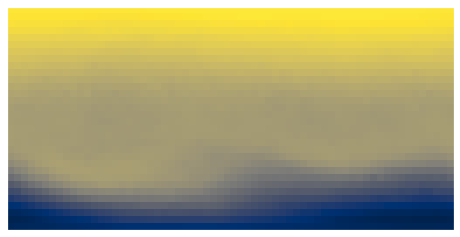

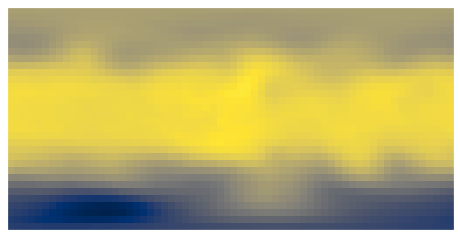

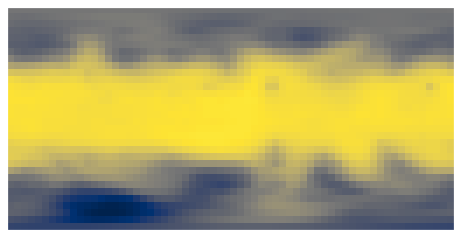

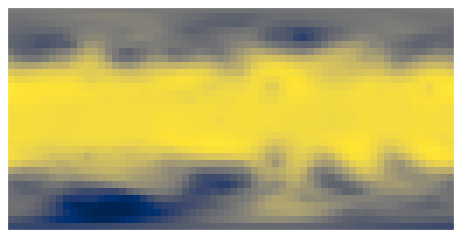

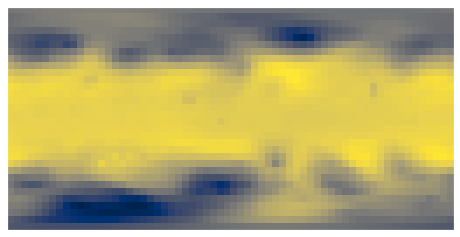

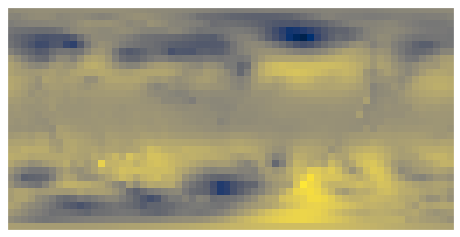

In [60]:
for lev in z.level.values[::2]:
    plot_map(z.isel(time=0).sel(level=lev), cmap='cividis', save_fn=f'../figures/z_{str(lev).zfill(4)}_t0.jpeg')

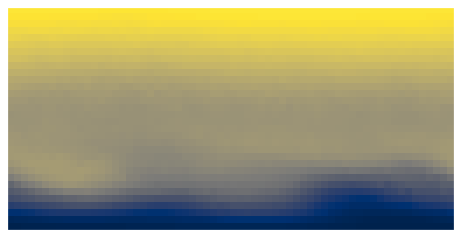

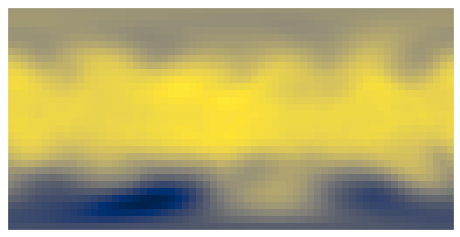

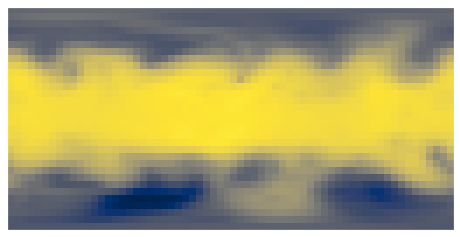

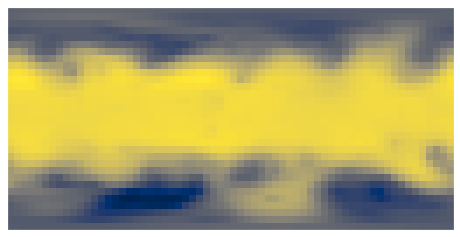

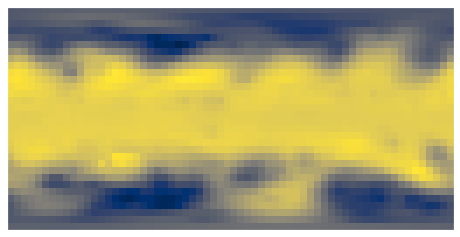

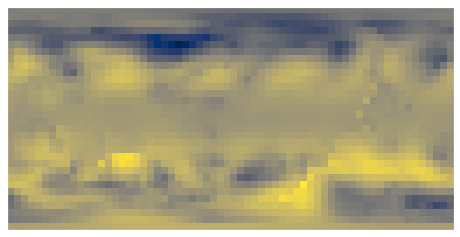

In [61]:
for lev in z.level.values[::2]:
    plot_map(z.isel(time=5*24).sel(level=lev), cmap='cividis', save_fn=f'../figures/z_{str(lev).zfill(4)}_t5.jpeg')

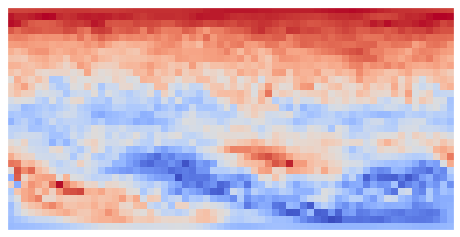

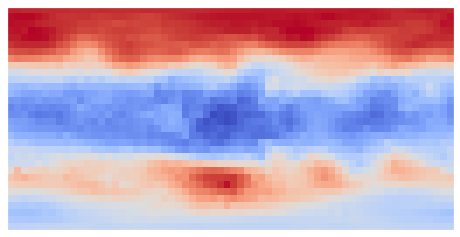

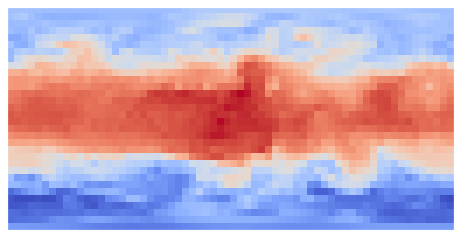

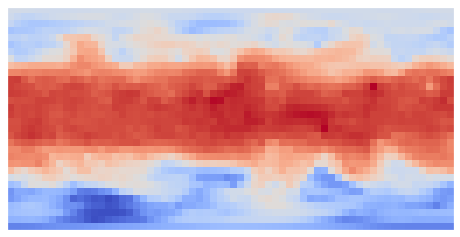

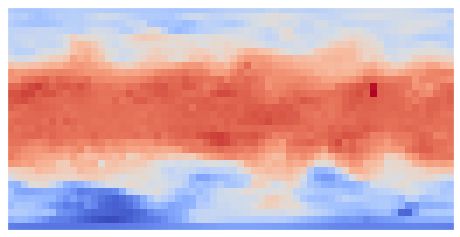

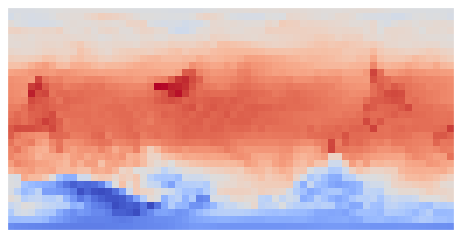

In [62]:
for lev in z.level.values[::2]:
    plot_map(t.isel(time=0).sel(level=lev), cmap='coolwarm', save_fn=f'../figures/t_{str(lev).zfill(4)}_t0.jpeg')

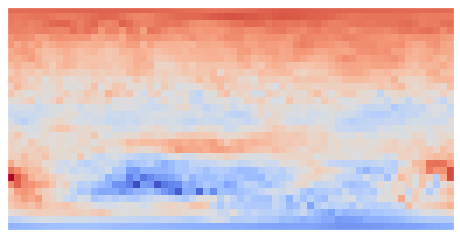

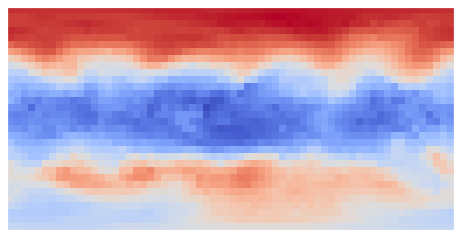

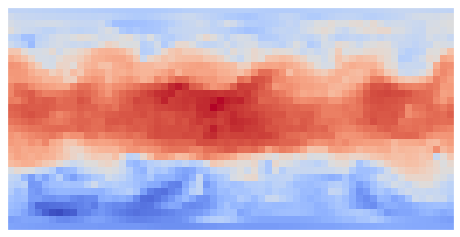

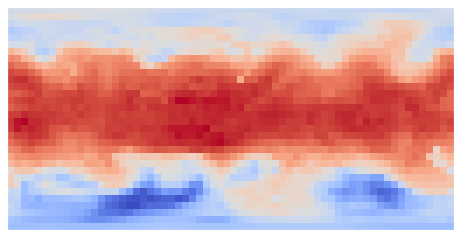

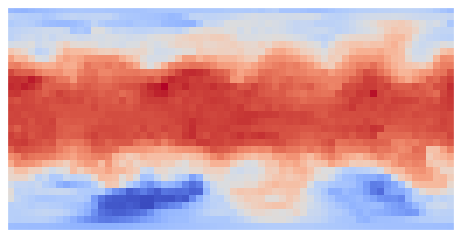

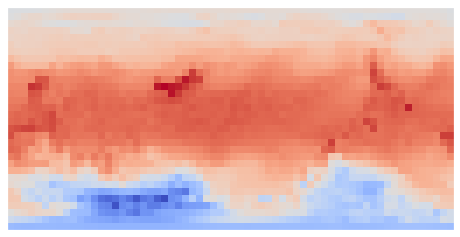

In [63]:
for lev in z.level.values[::2]:
    plot_map(t.isel(time=5*24).sel(level=lev), cmap='coolwarm', save_fn=f'../figures/t_{str(lev).zfill(4)}_t5.jpeg')

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


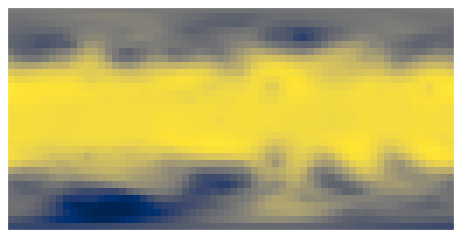

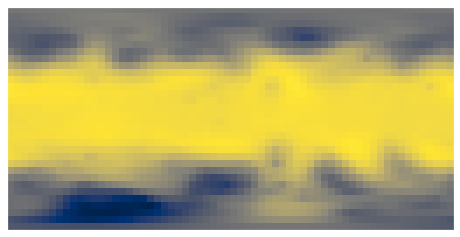

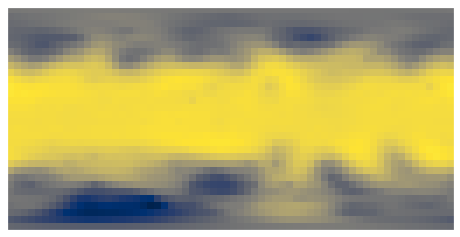

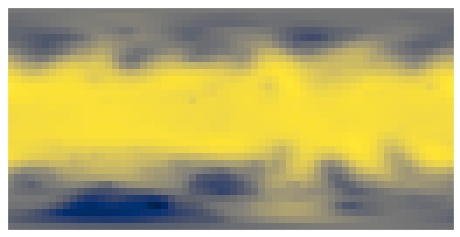

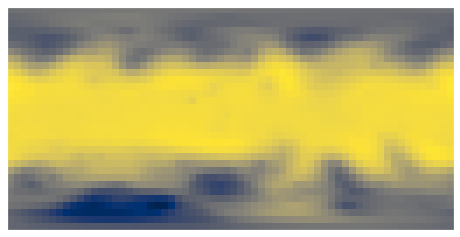

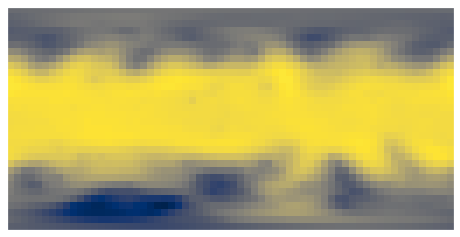

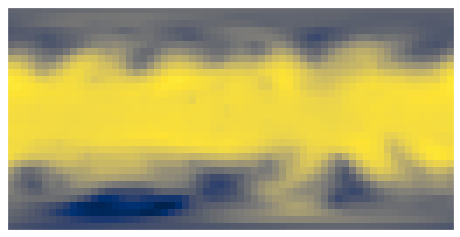

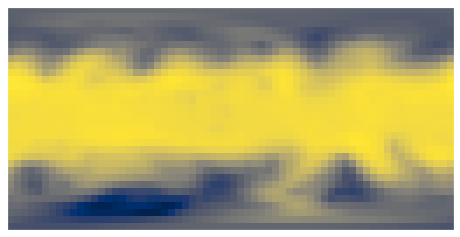

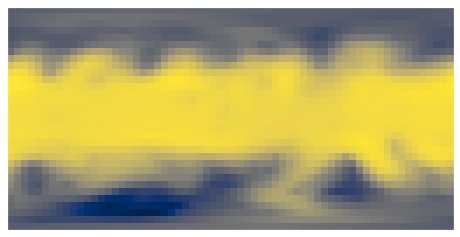

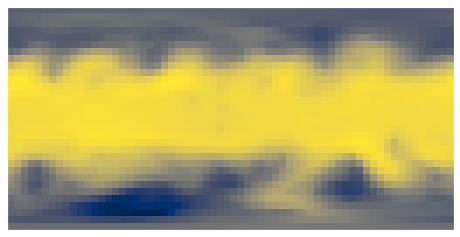

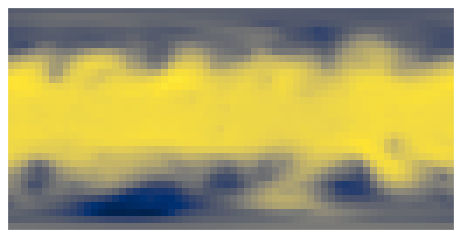

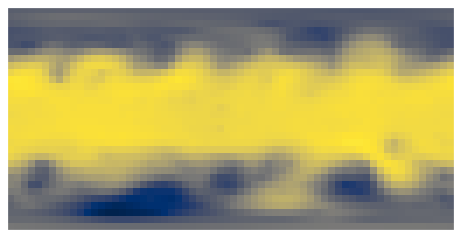

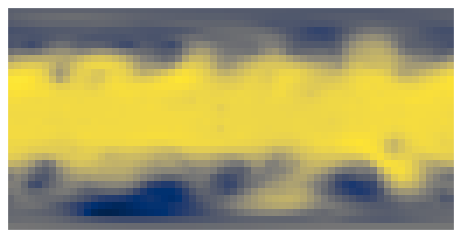

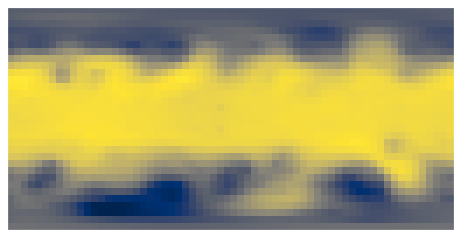

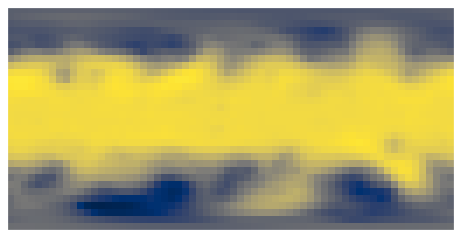

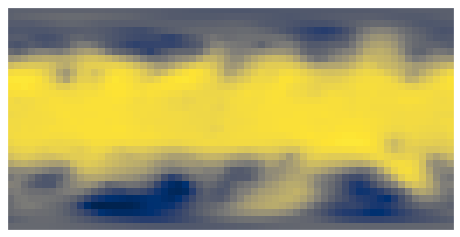

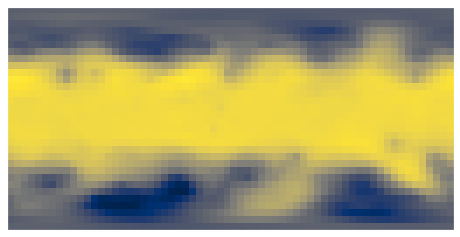

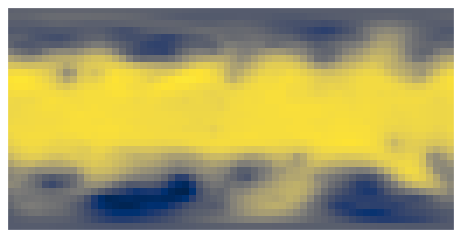

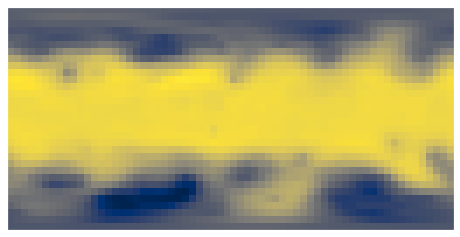

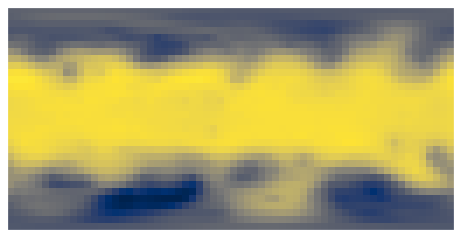

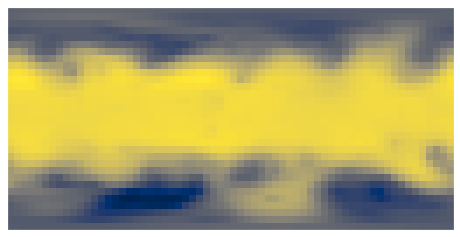

In [64]:
for time in range(0, 126, 6):
    plot_map(z.isel(time=time).sel(level=500), cmap='cividis', save_fn=f'../figures/z500_t{time}h.jpeg')